In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
df = pd.read_csv('~/Downloads/techcrunch_posts.csv')

In [42]:
df.head()

,authors,category,content,date,id,img_src,section,tags,title,topics,url
0,Dale Chang,Startups,\n\nTech investing isn’t what it used to be — ...,2016-10-15,1401293,https://tctechcrunch2011.files.wordpress.com/2...,startups/,data,How startups can use data to grow smarter,NaN,https://techcrunch.com/2016/10/15/how-startups...
1,"Ben Narasin,Jeremy Abelson",Fundings & Exits,\n\nThe IPO market is poised to make an almost...,2016-10-14,1399050,https://tctechcrunch2011.files.wordpress.com/2...,startups/,ipo,"While the IPO market roars back, venture remai...",NaN,https://techcrunch.com/2016/10/14/while-the-ip...
2,Matthew Lynley,Apps,Under pressure from shoppers complaining about...,2016-10-14,1401954,https://tctechcrunch2011.files.wordpress.com/2...,startups/,apoorva-mehta,"Instacart reverses course, re-introducing tips...",instacart,https://techcrunch.com/2016/10/14/instacart-re...
3,"Matthew Lynley,Ingrid Lunden",Fundings & Exits,"PayPal, the giant digital payments company tha...",2016-10-14,1390023,https://tctechcrunch2011.files.wordpress.com/2...,startups/,gofundme,PayPal mulled buying GoFundMe,paypal,https://techcrunch.com/2016/10/14/paypal-gobuyme/
4,Megan Rose Dickey,Startups,"Uber, the ridesharing behemoth that recently b...",2016-10-13,1401633,https://tctechcrunch2011.files.wordpress.com/2...,startups/,lawsuits,Uber hits another roadblock,uber,https://techcrunch.com/2016/10/13/uber-hits-an...


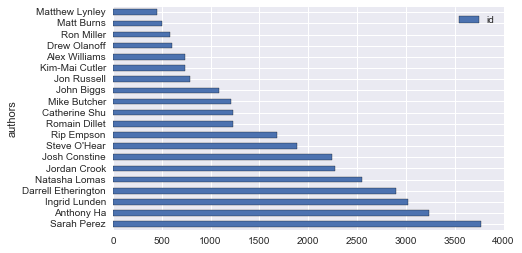

In [19]:
## top 20 authors
authors = df.groupby('authors',as_index=False)['id'].count()
authors = authors.sort_values(by=['id'],ascending=False)[:20]
authors.plot(kind='barh',x = 'authors',y = 'id',figsize=(7,4))

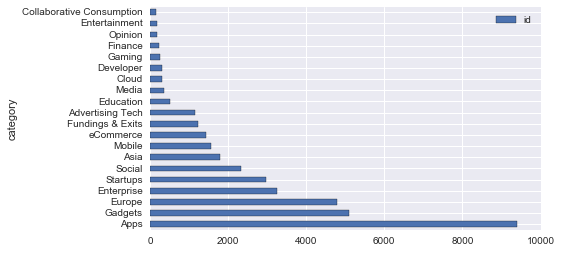

In [24]:
## top 20 category
category = df.groupby('category',as_index=False)['id'].count()
category = category.sort_values(by=['id'],ascending=False)[:20]
category.plot(kind='barh',x='category',y='id',figsize=(7,4))

In [27]:
from IPython.display import display,Image

In [39]:
## top 10 image
'''
image = df.groupby('img_src',as_index=False)['id'].count()
image = image.sort_values(by=['id'],ascending=False)[:10].reset_index()
for i in xrange(len(image)):
    display(Image(url=image['img_src'][i],width=300))
'''

"\nimage = df.groupby('img_src',as_index=False)['id'].count()\nimage = image.sort_values(by=['id'],ascending=False)[:10].reset_index()\nfor i in xrange(len(image)):\n    display(Image(url=image['img_src'][i],width=300))\n"

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39115 entries, 0 to 39114
Data columns (total 11 columns):
authors     38815 non-null object
category    38393 non-null object
content     39061 non-null object
date        39115 non-null object
id          39115 non-null int64
img_src     39115 non-null object
section     39115 non-null object
tags        34148 non-null object
title       39115 non-null object
topics      5604 non-null object
url         39115 non-null object
dtypes: int64(1), object(10)
memory usage: 3.3+ MB


In [87]:
from sklearn.cross_validation import train_test_split
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from nltk.corpus import stopwords
import re
import nltk

In [79]:
df['tages'] = df['tags'].apply(lambda x:['No tags'] if str(x) == 'NaN' else str(x).split(','))
df['authors'] = df['authors'].apply(lambda x:str(x).split(','))
df['topics'] = df['topics'].apply(lambda x:str(x).split(','))
df['content'].fillna(0,inplace=True)
df = df[df['content'] !=0]
df.reset_index(drop=True,inplace=True)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39061 entries, 0 to 39060
Data columns (total 12 columns):
authors     39061 non-null object
category    38339 non-null object
content     39061 non-null object
date        39061 non-null object
id          39061 non-null int64
img_src     39061 non-null object
section     39061 non-null object
tags        34097 non-null object
title       39061 non-null object
topics      39061 non-null object
url         39061 non-null object
tages       39061 non-null object
dtypes: int64(1), object(11)
memory usage: 3.6+ MB


In [80]:
## remove stopwords
def convert_meaningful(content):
    letters = re.sub("[^a-zA-Z]", " ", content) 
    words = letters.lower().split()                             
    stopword = set(stopwords.words("english"))              # stopwords is high frequency words such the,a etc.
    meaningful_words = [w for w in words if w not in stopword]  
    return( " ".join( meaningful_words )) 

In [81]:
clean_content=[]
for content in df['content']:
    clean_content.append(convert_meaningful(content))

In [84]:
tfidf = TfidfVectorizer()
features = tfidf.fit_transform(clean_content)

In [89]:
knn = NearestNeighbors(n_neighbors=30,metric='cosine',algorithm='brute')
knn_model = knn.fit(features)

In [125]:
def recommend(author):
    indexes = []
    for i in xrange(len(df)):
        if author in df['authors'][i]:
            indexes.append(i)
    tmp_df = df.iloc[indexes,:]
    author_content = []
    for i in tmp_df['content']:
        author_content.append(convert_meaningful(i))
    wordcloud = WordCloud(background_color='black',width = 3500, height = 2000).generate(author_content[0])
    ## the latest articles of author
    ##neighbors = knn_model.kneighbors(features[indexes[0]])[1].tolist()[0][2:]
    ## total 30 groups
    neighbors = knn_model.kneighbors(features[indexes[0]])[1].tolist()[0]
    
    all_articles = df.iloc[neighbors,:]
    all_articles.reset_index(inplace=True,drop=True)
    kept_index =[]
    for i in xrange(len(all_articles)):
        if author in all_articles['authors'][i]:
            pass
        else:
            kept_index.append(i)
            
    ## top 5 articles recommended to author
    recommend_article = df.iloc[kept_index,:]
    recommend_article.reset_index(drop=True,inplace=True)
    recommend_article = recommend_article.iloc[0:5,:]
    
    print '==' * 30
    print 'the article of ' + author + 'is always featured by the following words' 
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
    print 'top 5 articles recommended to %s' %(author)
    for i in xrange(len(recommend_article)):
        print 'title : %s , author : %s ,url %s ' %(recommend_article['title'][i] ,
                                                    recommend_article['authors'][i],
                                                    recommend_article['url'][i])
    
    print '==' * 30
    
    

the article of Bastiaan Janmaatis always featured by the following words


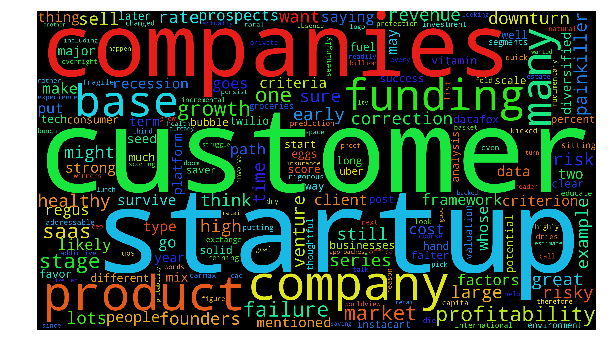

top 5 articles recommended to Bastiaan Janmaat
title : While the IPO market roars back, venture remains leery , author : ['Ben Narasin', 'Jeremy Abelson'] ,url https://techcrunch.com/2016/10/14/while-the-ipo-market-roars-back-venture-remains-leery/ 
title : Instacart reverses course, re-introducing tips for shoppers , author : ['Matthew Lynley'] ,url https://techcrunch.com/2016/10/14/instacart-reverses-course-re-introducing-tips/ 
title : PayPal mulled buying GoFundMe , author : ['Matthew Lynley', 'Ingrid Lunden'] ,url https://techcrunch.com/2016/10/14/paypal-gobuyme/ 
title : Uber hits another roadblock , author : ['Megan Rose Dickey'] ,url https://techcrunch.com/2016/10/13/uber-hits-another-roadblock/ 
title : From the distributed workforce to the partnered economy , author : ['Ajay Chopra'] ,url https://techcrunch.com/2016/10/13/from-the-distributed-workforce-to-the-partnered-economy/ 


In [126]:
recommend('Bastiaan Janmaat')